In [79]:
import pandas as pd
import numpy as np
import os
import random
from tqdm.auto import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jeju-dataset/sample_submission.csv
/kaggle/input/jeju-dataset/train.csv
/kaggle/input/jeju-dataset/test.csv
/kaggle/input/jeju-dataset/international_trade.csv
/kaggle/input/jeju-dataset-2/sample_submission.csv
/kaggle/input/jeju-dataset-2/train.csv
/kaggle/input/jeju-dataset-2/test.csv
/kaggle/input/jeju-dataset-2/international_trade.csv


In [80]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

DATA_PATH = '/kaggle/input/jeju-dataset-2/'

SEED = 42

train_df = pd.read_csv(f'{DATA_PATH}train.csv')
test_df = pd.read_csv(f'{DATA_PATH}test.csv')
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
international = pd.read_csv(f'{DATA_PATH}international_trade.csv')

In [81]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostRegressor
from sklearn import tree
# from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer

In [82]:
SEED=42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED) # Seed 고정

In [83]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

DATA_PATH = '/kaggle/input/jeju-dataset-2/'

SEED = 42

train_df = pd.read_csv(f'{DATA_PATH}train.csv')
test_df = pd.read_csv(f'{DATA_PATH}test.csv')
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
international = pd.read_csv(f'{DATA_PATH}international_trade.csv')

In [84]:
train_df.rename(columns={'supply(kg)':'supply', 'price(원/kg)':'price'}, inplace=True)
train_df

,ID,timestamp,item,corporation,location,supply,price
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


## 시간 Feature

In [85]:
# 공휴일
holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01']

In [86]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['year'] = train_df['timestamp'].dt.year
train_df['week'] = train_df['timestamp'].dt.isocalendar().week
train_df['day'] = train_df['timestamp'].dt.day
train_df['day_of_week'] = train_df['timestamp'].dt.dayofweek
train_df['sin_week'] = np.sin(2 * np.pi * train_df['week'] / 4)
train_df['cos_week'] = np.cos(2 * np.pi * train_df['week'] / 4)
train_df['sin_dayofweek'] = np.sin(2 * np.pi * (train_df['day_of_week'] + 1) / 7)
train_df['cos_dayofweek'] = np.cos(2 * np.pi * (train_df['day_of_week'] + 1) / 7)
train_df['holiday'] = np.where((train_df.day_of_week >= 5) | (train_df.timestamp.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['year'] = test_df['timestamp'].dt.year
test_df['week'] = test_df['timestamp'].dt.isocalendar().week
test_df['day'] = test_df['timestamp'].dt.day
test_df['day_of_week'] = test_df['timestamp'].dt.dayofweek
test_df['sin_week'] = np.sin(2 * np.pi * test_df['week'] / 4)
test_df['cos_week'] = np.cos(2 * np.pi * test_df['week'] / 4)
test_df['sin_dayofweek'] = np.sin(2 * np.pi * (test_df['day_of_week'] + 1) / 7)
test_df['cos_dayofweek'] = np.cos(2 * np.pi * (test_df['day_of_week'] + 1) / 7)
test_df['holiday'] = np.where((test_df.day_of_week >= 5) | (test_df.timestamp.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

In [87]:
train_df['month'] = train_df['timestamp'].dt.to_period('M')
test_df['month'] = test_df['timestamp'].dt.to_period('M')

train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,week,day,day_of_week,sin_week,cos_week,sin_dayofweek,cos_dayofweek,holiday,month
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,1.0,0.0,0.974928,-0.222521,1,2019-01
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2,1.0,0.0,0.433884,-0.900969,0,2019-01
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3,1.0,0.0,-0.433884,-0.900969,0,2019-01
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4,1.0,0.0,-0.974928,-0.222521,0,2019-01
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5,1.0,0.0,-0.781831,0.623490,1,2019-01


In [88]:
item_month_price = train_df.groupby(['item', 'month'])
agg = {'price' : ['mean', 'max']}
price_df = item_month_price.agg(agg).reset_index()
price_df

item    month        price        
                          mean     max
0     BC  2019-01  1278.086022  2689.0
1     BC  2019-02  1152.563492  2925.0
2     BC  2019-03  1772.620072  4149.0
3     BC  2019-04  2288.400000  6929.0
4     BC  2019-05   658.265233  5965.0
..   ...      ...          ...     ...
250   TG  2022-11  1361.850000  2526.0
251   TG  2022-12  1696.103226  4202.0
252   TG  2023-01  1782.693548  8000.0
253   TG  2023-02  2250.250000  8500.0
254   TG  2023-03  3442.633333  6382.0

[255 rows x 4 columns]

In [89]:
price_df.columns = ['item', 'month', 'month_price_mean', 'month_price_max']
train_df = pd.merge(train_df, price_df, on=['item', 'month'], how='left')
train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,week,day,day_of_week,sin_week,cos_week,sin_dayofweek,cos_dayofweek,holiday,month,month_price_mean,month_price_max
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,1.0,0.0,0.974928,-0.222521,1,2019-01,1485.383871,4031.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2,1.0,0.0,0.433884,-0.900969,0,2019-01,1485.383871,4031.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3,1.0,0.0,-0.433884,-0.900969,0,2019-01,1485.383871,4031.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4,1.0,0.0,-0.974928,-0.222521,0,2019-01,1485.383871,4031.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5,1.0,0.0,-0.781831,0.623490,1,2019-01,1485.383871,4031.0


In [90]:
# 테스트셋 반영
test_df = pd.merge(test_df, price_df, on=['item', 'month'], how='left')
test_df.head()

,ID,timestamp,item,corporation,location,year,week,day,day_of_week,sin_week,cos_week,sin_dayofweek,cos_dayofweek,holiday,month,month_price_mean,month_price_max
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,9,4,5,1.0,0.0,-7.818315e-01,0.623490,1,2023-03,3442.633333,6382.0
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,9,5,6,1.0,0.0,-2.449294e-16,1.000000,1,2023-03,3442.633333,6382.0
2,TG_A_J_20230306,2023-03-06,TG,A,J,2023,10,6,0,0.0,-1.0,7.818315e-01,0.623490,0,2023-03,3442.633333,6382.0
3,TG_A_J_20230307,2023-03-07,TG,A,J,2023,10,7,1,0.0,-1.0,9.749279e-01,-0.222521,0,2023-03,3442.633333,6382.0
4,TG_A_J_20230308,2023-03-08,TG,A,J,2023,10,8,2,0.0,-1.0,4.338837e-01,-0.900969,0,2023-03,3442.633333,6382.0


In [91]:
item_month_supply = train_df.groupby(['item', 'month'])
agg = {'supply' : ['mean', 'max']}
supply_df = item_month_supply.agg(agg).reset_index()
supply_df

item    month        supply          
                           mean       max
0     BC  2019-01   2494.161290   14584.0
1     BC  2019-02   2288.412698   15184.0
2     BC  2019-03   2056.946237   14048.0
3     BC  2019-04   1347.229630   10136.0
4     BC  2019-05    124.301075    3792.0
..   ...      ...           ...       ...
250   TG  2022-11  29303.189000  104781.0
251   TG  2022-12  34294.561290  129891.0
252   TG  2023-01  27517.410968  127048.0
253   TG  2023-02  19588.908571   78797.0
254   TG  2023-03  16526.743333   47819.0

[255 rows x 4 columns]

In [92]:
supply_df.columns = ['item', 'month', 'month_supply_mean', 'month_supply_max']
train_df = pd.merge(train_df, supply_df, on=['item', 'month'], how='left')
train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,week,day,...,sin_week,cos_week,sin_dayofweek,cos_dayofweek,holiday,month,month_price_mean,month_price_max,month_supply_mean,month_supply_max
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,...,1.0,0.0,0.974928,-0.222521,1,2019-01,1485.383871,4031.0,47433.957097,268073.4
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,...,1.0,0.0,0.433884,-0.900969,0,2019-01,1485.383871,4031.0,47433.957097,268073.4
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,...,1.0,0.0,-0.433884,-0.900969,0,2019-01,1485.383871,4031.0,47433.957097,268073.4
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,...,1.0,0.0,-0.974928,-0.222521,0,2019-01,1485.383871,4031.0,47433.957097,268073.4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,...,1.0,0.0,-0.781831,0.623490,1,2019-01,1485.383871,4031.0,47433.957097,268073.4


In [93]:
# 테스트셋 반영
test_df = pd.merge(test_df, supply_df, on=['item', 'month'], how='left')
test_df.head()

,ID,timestamp,item,corporation,location,year,week,day,day_of_week,sin_week,cos_week,sin_dayofweek,cos_dayofweek,holiday,month,month_price_mean,month_price_max,month_supply_mean,month_supply_max
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,9,4,5,1.0,0.0,-7.818315e-01,0.623490,1,2023-03,3442.633333,6382.0,16526.743333,47819.0
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,9,5,6,1.0,0.0,-2.449294e-16,1.000000,1,2023-03,3442.633333,6382.0,16526.743333,47819.0
2,TG_A_J_20230306,2023-03-06,TG,A,J,2023,10,6,0,0.0,-1.0,7.818315e-01,0.623490,0,2023-03,3442.633333,6382.0,16526.743333,47819.0
3,TG_A_J_20230307,2023-03-07,TG,A,J,2023,10,7,1,0.0,-1.0,9.749279e-01,-0.222521,0,2023-03,3442.633333,6382.0,16526.743333,47819.0
4,TG_A_J_20230308,2023-03-08,TG,A,J,2023,10,8,2,0.0,-1.0,4.338837e-01,-0.900969,0,2023-03,3442.633333,6382.0,16526.743333,47819.0


In [94]:
# 공급과 가격의 상관관계
sup_price_corr = train_df['supply'].corr(train_df['price'])
sup_price_corr

-0.0022967366004861545

In [95]:
# timestamp
train_df['timestamp'] = (train_df['timestamp'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
test_df['timestamp'] = (test_df['timestamp'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

train_df['timestamp']

0        1546300800
1        1546387200
2        1546473600
3        1546560000
4        1546646400
            ...    
59392    1677456000
59393    1677542400
59394    1677628800
59395    1677715200
59396    1677801600
Name: timestamp, Length: 59397, dtype: int64

In [96]:
# month
train_df['month'] = (train_df['month'].dt.to_timestamp() - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
test_df['month'] = (test_df['month'].dt.to_timestamp() - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

test_df['month']

0       1677628800
1       1677628800
2       1677628800
3       1677628800
4       1677628800
           ...    
1087    1677628800
1088    1677628800
1089    1677628800
1090    1677628800
1091    1677628800
Name: month, Length: 1092, dtype: int64

In [97]:
international = pd.read_csv(f'{DATA_PATH}international_trade.csv')

In [98]:
international = international.rename(columns={
    '기간': 'month',
    '품목명': 'item',
    '수출 중량': 'exWeight',
    '수출 금액': 'exValue',
    '수입 중량': 'imWeight',
    '수입 금액': 'imValue',
    '무역수지': 'tradeBalance'
})

international.head()

,month,item,exWeight,exValue,imWeight,imValue,tradeBalance
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


In [99]:
international['month'] = pd.to_datetime(international['month'], format='%Y-%m')
international['month'] = (international['month'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

In [100]:
selected_items = international[international['item'].str.contains('감귤|브로콜리|무|당근|양배추')].copy()

selected_items['item'] = selected_items['item'].replace({
    '감귤': 'TG',
    '브로콜리': 'BC',
    '무': 'RD',
    '당근': 'CR',
    '양배추': 'CB'
}, regex = True)

selected_items['item'] = selected_items['item'].str.replace('.*감귤.*', 'TG')
selected_items['item'] = selected_items['item'].str.replace('.*브로콜리.*', 'BC')
selected_items['item'] = selected_items['item'].str.replace('.*무.*', 'RD')
selected_items['item'] = selected_items['item'].str.replace('.*당근.*', 'CR')
selected_items['item'] = selected_items['item'].str.replace('.*양배추.*', 'CB')

selected_items

/tmp/ipykernel_47/2454438103.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  selected_items['item'] = selected_items['item'].str.replace('.*감귤.*', 'TG')
/tmp/ipykernel_47/2454438103.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  selected_items['item'] = selected_items['item'].str.replace('.*브로콜리.*', 'BC')
/tmp/ipykernel_47/2454438103.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  selected_items['item'] = selected_items['item'].str.replace('.*무.*', 'RD')
/tmp/ipykernel_47/2454438103.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  selected_items['item'] = selected_items['item'].str.replace('.*당근.*', 'CR')
/tmp/ipykernel_47/2454438103.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  selected_items['item'] = selected_i

,month,item,exWeight,exValue,imWeight,imValue,tradeBalance
3,1546300800,꽃CB와 BC(broccoli),160,1,638913,563,-562
4,1546300800,방울다다기 CB,0,0,7580,38,-38
5,1546300800,CB,184650,94,395802,90,4
8,1546300800,CR,23150,22,7466150,2955,-2934
12,1546300800,RD화과,2627,23,94529,464,-441
...,...,...,...,...,...,...,...
1250,1675209600,CB,13188,13,377456,104,-91
1253,1675209600,CR,22510,20,9260020,3758,-3737
1254,1675209600,순RD,4000,4,2,0,4
1258,1675209600,RD화과,1319,14,104566,454,-440


In [101]:
train_df = train_df.merge(selected_items, on=['month', 'item'], how='left')
test_df = test_df.merge(selected_items, on=['month', 'item'], how='left')


train_df['exPrice'] = train_df['exValue'] / train_df['exWeight']
train_df['imPrice'] = train_df['imValue'] / train_df['imWeight']

test_df['exPrice'] = test_df['exValue'] / test_df['exWeight']
test_df['imPrice'] = test_df['imValue'] / test_df['imWeight']

train_df

,ID,timestamp,item,corporation,location,supply,price,year,week,day,...,month_price_max,month_supply_mean,month_supply_max,exWeight,exValue,imWeight,imValue,tradeBalance,exPrice,imPrice
0,TG_A_J_20190101,1546300800,TG,A,J,0.0,0.0,2019,1,1,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
1,TG_A_J_20190102,1546387200,TG,A,J,0.0,0.0,2019,1,2,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
2,TG_A_J_20190103,1546473600,TG,A,J,60601.0,1728.0,2019,1,3,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
3,TG_A_J_20190104,1546560000,TG,A,J,25000.0,1408.0,2019,1,4,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
4,TG_A_J_20190105,1546646400,TG,A,J,32352.0,1250.0,2019,1,5,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,1677456000,RD,F,J,452440.0,468.0,2023,9,27,...,1900.0,55495.388393,657220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59393,RD_F_J_20230228,1677542400,RD,F,J,421980.0,531.0,2023,9,28,...,1900.0,55495.388393,657220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59394,RD_F_J_20230301,1677628800,RD,F,J,382980.0,574.0,2023,9,1,...,709.0,63313.333333,477220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59395,RD_F_J_20230302,1677715200,RD,F,J,477220.0,523.0,2023,9,2,...,709.0,63313.333333,477220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [103]:
# 품목별 평균 가격
item_mean_price = train_df.groupby('item')['price'].mean().reset_index()
item_mean_price.columns = ['item', 'item_mean_price']

train_df = train_df.merge(item_mean_price, on='item', how='left')
test_df = test_df.merge(item_mean_price, on='item', how='left')

# 법인별 평균 가격
corp_mean_price = train_df.groupby('corporation')['price'].mean().reset_index()
corp_mean_price.columns = ['corporation', 'corp_mean_price']

train_df = train_df.merge(corp_mean_price, on='corporation', how='left')
test_df = test_df.merge(corp_mean_price, on='corporation', how='left')

# 지역별 평균 가격
location_mean_price = train_df.groupby('location')['price'].mean().reset_index()
location_mean_price.columns = ['location', 'location_mean_price']

train_df = train_df.merge(location_mean_price, on='location', how='left')
test_df = test_df.merge(location_mean_price, on='location', how='left')

In [104]:
obj_cols = ['item', 'corporation', 'location']

for col in obj_cols:
    enc = LabelEncoder()
    train_df[col]=enc.fit_transform(train_df[col])
    test_df[col]=enc.transform(test_df[col])

train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,week,day,...,exWeight,exValue,imWeight,imValue,tradeBalance,exPrice,imPrice,item_mean_price,corp_mean_price,location_mean_price
0,TG_A_J_20190101,1546300800,4,0,0,0.0,0.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
1,TG_A_J_20190102,1546387200,4,0,0,0.0,0.0,2019,1,2,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
2,TG_A_J_20190103,1546473600,4,0,0,60601.0,1728.0,2019,1,3,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
3,TG_A_J_20190104,1546560000,4,0,0,25000.0,1408.0,2019,1,4,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
4,TG_A_J_20190105,1546646400,4,0,0,32352.0,1250.0,2019,1,5,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148


In [105]:
train_df['week'] = train_df['week'].astype(float)
test_df['week'] = test_df['week'].astype(float)

In [106]:
train_df['sin_week'] =train_df['sin_week'].astype(float)
train_df['cos_week'] =train_df['cos_week'].astype(float)

test_df['sin_week'] =test_df['sin_week'].astype(float)
test_df['cos_week'] =test_df['cos_week'].astype(float)

In [107]:
train_df['imPrice'].unique()

array([0.        , 0.00260926, 0.00267519, 0.00271953, 0.00327099,
       0.00339048, 0.00614035, 0.00416994, 0.00125   , 0.00352962,
       0.00039579, 0.00039848, 0.00037091, 0.00041965, 0.00044101,
       0.00045852, 0.00039884, 0.00037193, 0.00036899, 0.00029921,
       0.00027575, 0.0002843 , 0.00031439, 0.00040764, 0.00046702,
       0.0003828 , 0.00034744, 0.00038985, 0.00037943, 0.00041877,
       0.00040734, 0.00035308, 0.00033765, 0.00034202, 0.00039297,
       0.00045599, 0.00060148, 0.0005827 , 0.0005837 , 0.00053499,
       0.00043739, 0.00034189, 0.00035189, 0.00034756, 0.00038482,
       0.00055184, 0.00066235, 0.00067989, 0.00046762, 0.00046601,
       0.0005011 , 0.00052403, 0.00045497, 0.00043104, 0.00042233,
       0.00039663, 0.00036592, 0.00033218, 0.00034542, 0.00040583,
       0.00022739, 0.00022907, 0.00026366, 0.00030571, 0.00035059,
       0.0002542 , 0.0002521 , 0.00026058, 0.0002651 , 0.00023773,
       0.00019595, 0.00020177, 0.00024284, 0.00025328, 0.00026

In [108]:
# autogluon 활용위해 id별로 

train_df['item_id'] = train_df.ID.str[0:6]
test_df['item_id'] = test_df.ID.str[0:6]

target = train_df['price']

In [109]:
# 불필요 컬럼 제거
X = train_df.drop(columns=['ID', 'supply'])
y = train_df['price']

test_X = test_df.drop(columns=['ID'])

X.shape, y.shape, test_X.shape

((59397, 30), (59397,), (1092, 29))

**## 검증 및 예측

In [1]:
!pip install autogluon

  Obtaining dependency information for autogluon from https://files.pythonhosted.org/packages/2e/42/f26592ecf3dc4e4edcbc5f7f7e3deba25b0681fad2ad04a82d12af17e3a4/autogluon-0.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for autogluon.core[all]==0.8.2 from https://files.pythonhosted.org/packages/e0/56/545adb1d388e78591cd7e36de0c8b889c1944de362bdaeec0f31d01890df/autogluon.core-0.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for autogluon.features==0.8.2 from https://files.pythonhosted.org/packages/bb/ea/7892719f78a30aee1bf42c4a0540fbae98bfbdf56b85fab79ffc437eb687/autogluon.features-0.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for autogluon.tabular[all]==0.8.2 from https://files.pythonhosted.org/packages/f3/dc/0bd8cadb9a5e2f3e5b12caaa6745357d912ffc7b8b75fb4e426a38331028/autogluon.tabular-0.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for autogluon.multimodal==0.8.2 from https://files.pythonhosted.org/packages/f

In [110]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

data = TimeSeriesDataFrame(X)
predictor = TimeSeriesPredictor(
    prediction_length=28,
    target="price",
    eval_metric="RMSE"
)
# seed 고정
predictor.fit(data, random_seed=SEED)

No path specified. Models will be saved in: "AutogluonModels/ag-20231112_095925/"
/opt/conda/lib/python3.10/site-packages/autogluon/timeseries/predictor.py:224: UserWarning: Detected frequency 'N' is not supported by TimeSeriesPredictor. This may lead to some models not working as intended. Please convert the timestamps to one of the supported frequencies: {'Y', 'M', 'T', 'S', 'A', 'Q', 'D', 'H', 'W', 'min'}. See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases for details.
  warnings.warn(
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'default',
 'num_val_windows': 1,
 'prediction_length': 28,
 'random_seed': 42,
 'target': 'price',
 'time_limit': None,
 'verbosity': 2}
Provided training data set with 59397 rows, 39 items (item = single time 

In [111]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: Naive_FULL | Skipping fit via cloning parent ...
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: Theta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['Naive_FULL', 'SeasonalNaive_FULL', 'Theta_FULL', 'AutoETS_FULL', 'WeightedEnsemble_FULL']
Total runtime: 0.02 s
Updated best model to 'WeightedEnsemble_FULL' (Previously 'WeightedEnsemble'). AutoGluon will default to using 'WeightedEnsemble_FULL' for predict().


{'Naive': 'Naive_FULL',
 'SeasonalNaive': 'SeasonalNaive_FULL',
 'Theta': 'Theta_FULL',
 'AutoETS': 'AutoETS_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

In [ ]:
pred = predictor.predict(data, random_seed=SEED)
pred

In [ ]:
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
submission['answer'] = pred.reset_index()['mean']
submission.loc[ submission['answer'] < 0.0, 'answer'] = 0.0
submission

## 상품별 데이터 예측 (39개)


In [143]:
!pip install sktime

In [144]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series


In [145]:
train_df['name'] = train_df['ID'].apply(lambda x : x[:6])
test_df['name'] = test_df['ID'].apply(lambda x : x[:6])


In [146]:
cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [147]:
!pip install catboost

  0%|          | 0/39 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


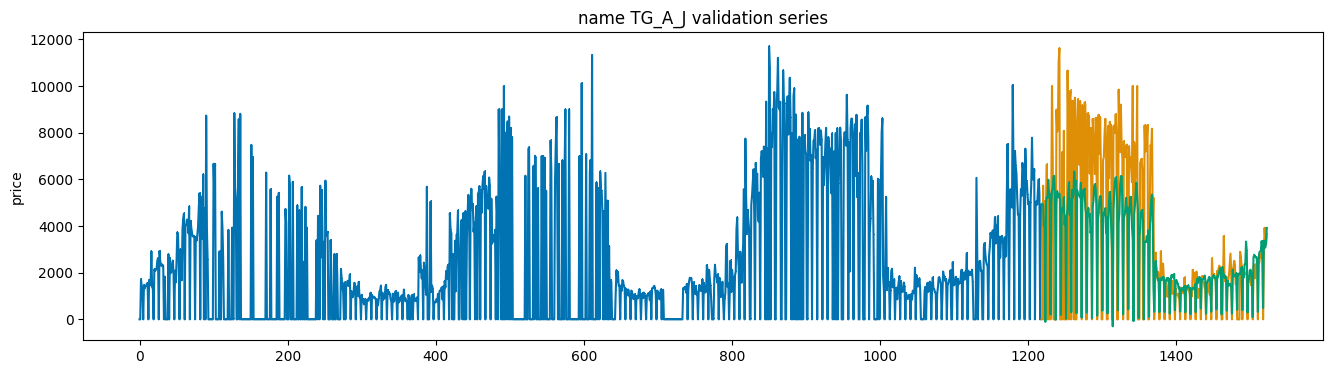

RMSE: 1173.7418974505715


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
  3%|▎         | 1/39 [00:21<13:53, 21.94s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

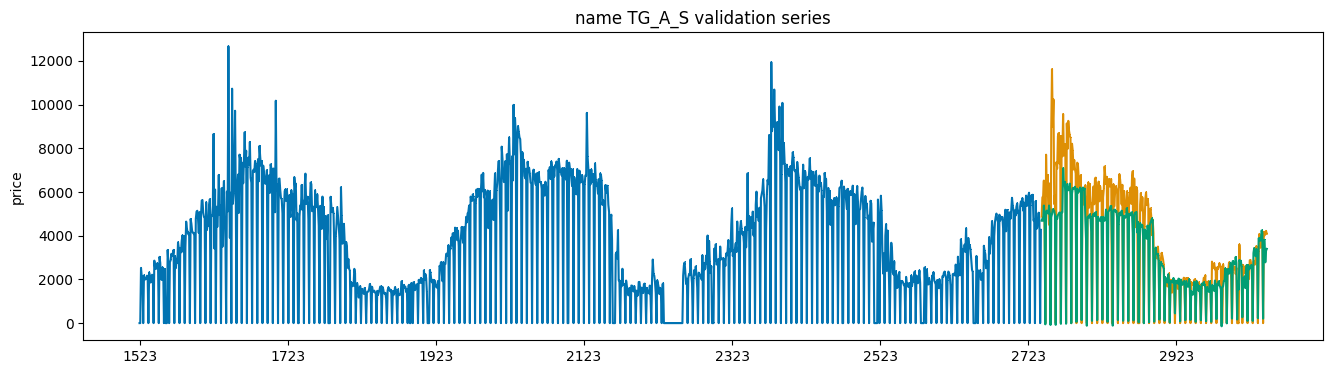

RMSE: 291.0217430728931


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
  5%|▌         | 2/39 [00:43<13:32, 21.96s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

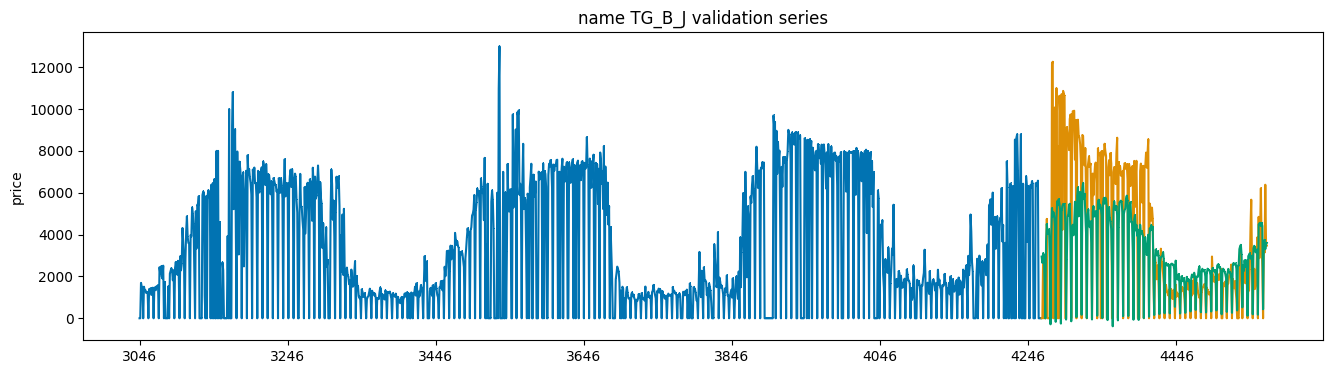

RMSE: 730.1528795873851


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
  8%|▊         | 3/39 [01:05<13:07, 21.89s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

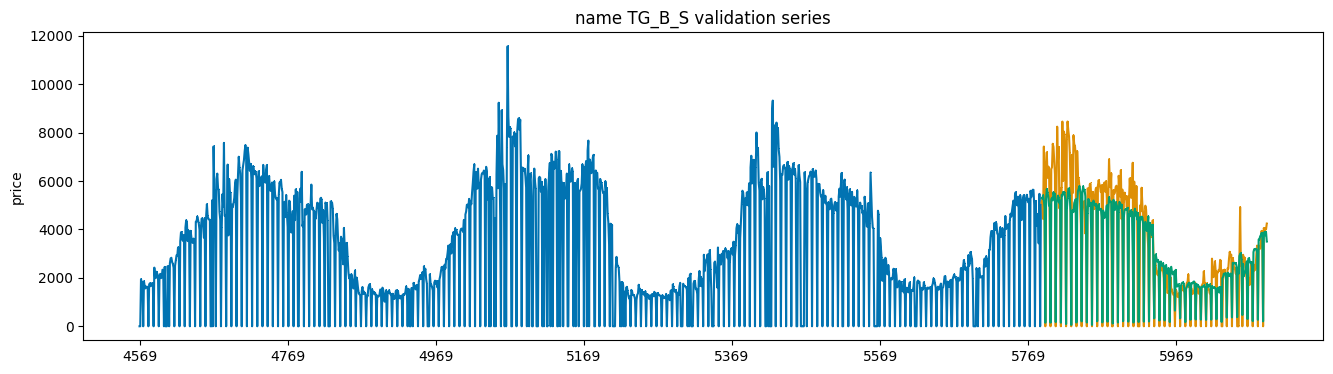

RMSE: 370.9010690581251


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 10%|█         | 4/39 [01:27<12:44, 21.85s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

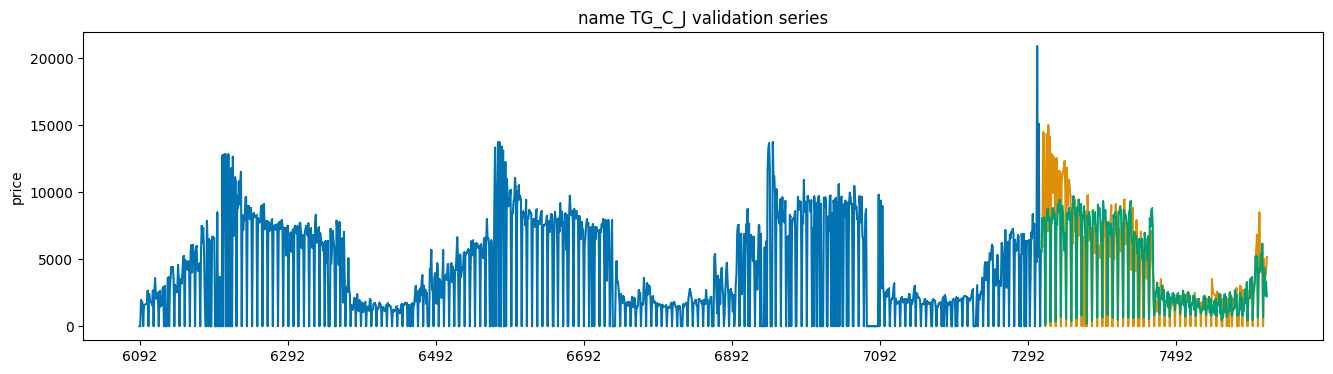

RMSE: 1128.3292758820594


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 13%|█▎        | 5/39 [01:49<12:24, 21.90s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

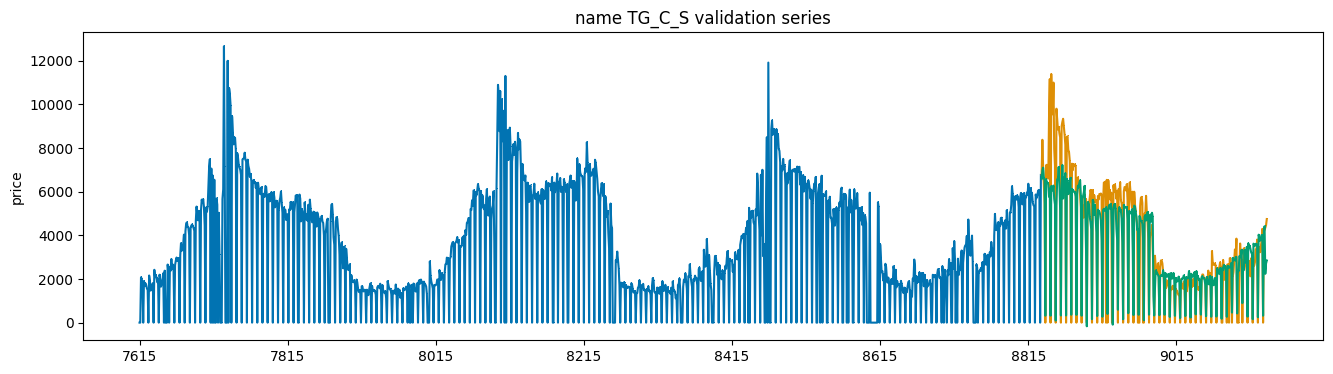

RMSE: 618.0886874591271


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 15%|█▌        | 6/39 [02:12<12:11, 22.16s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

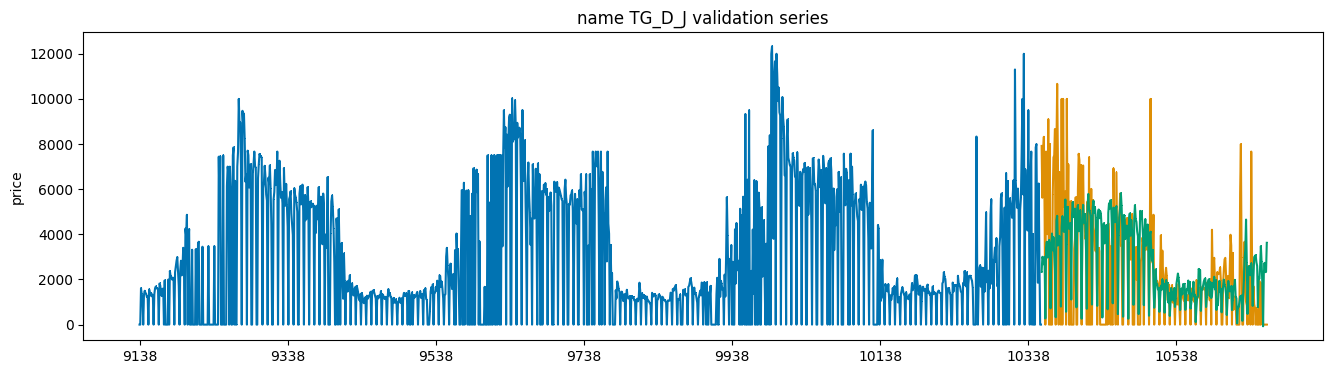

RMSE: 982.642276367888


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 18%|█▊        | 7/39 [02:34<11:46, 22.08s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

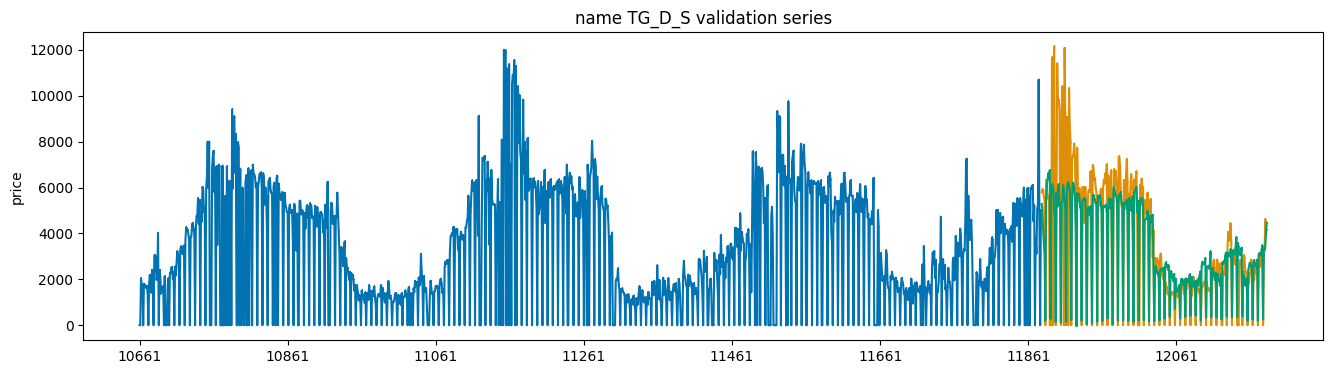

RMSE: 638.3609934373056


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 21%|██        | 8/39 [02:56<11:25, 22.11s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

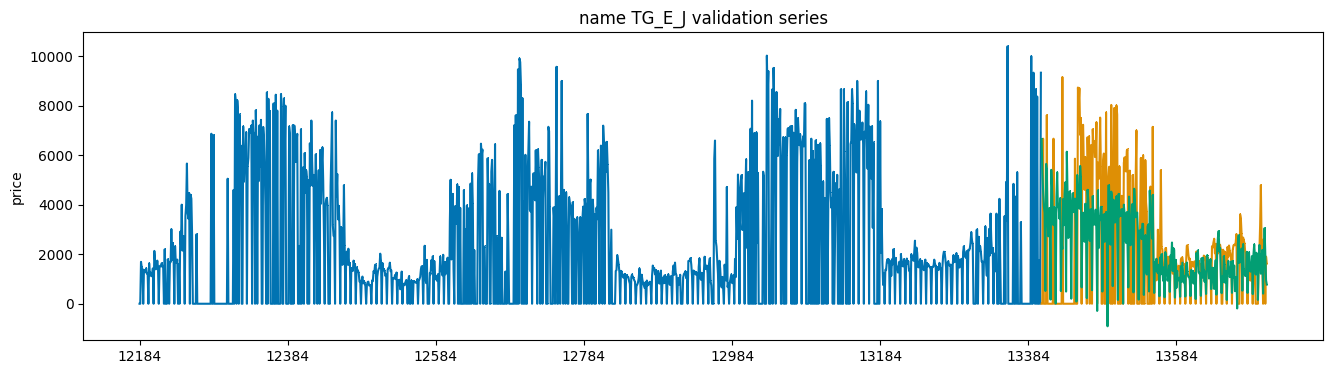

RMSE: 1327.7369011694498


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 23%|██▎       | 9/39 [03:18<11:02, 22.08s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

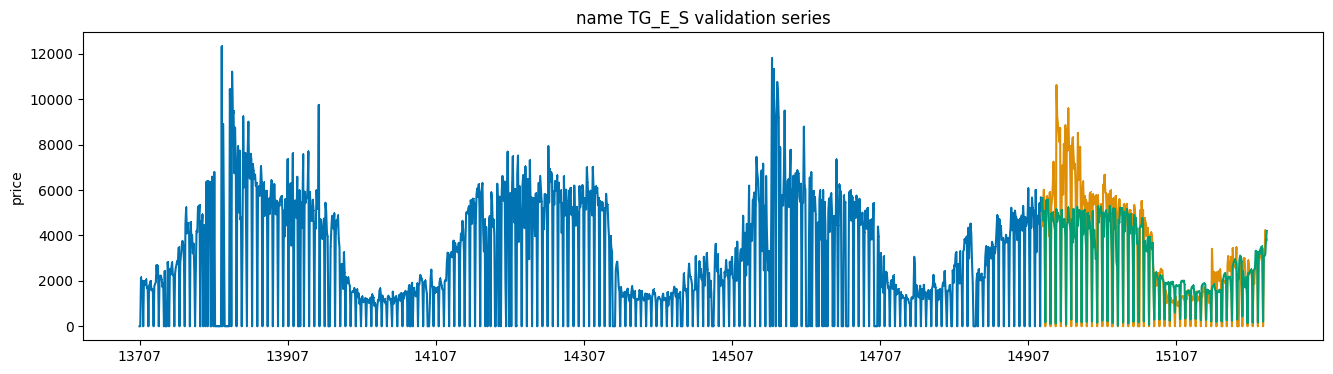

RMSE: 645.40970880782


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 26%|██▌       | 10/39 [03:40<10:43, 22.19s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

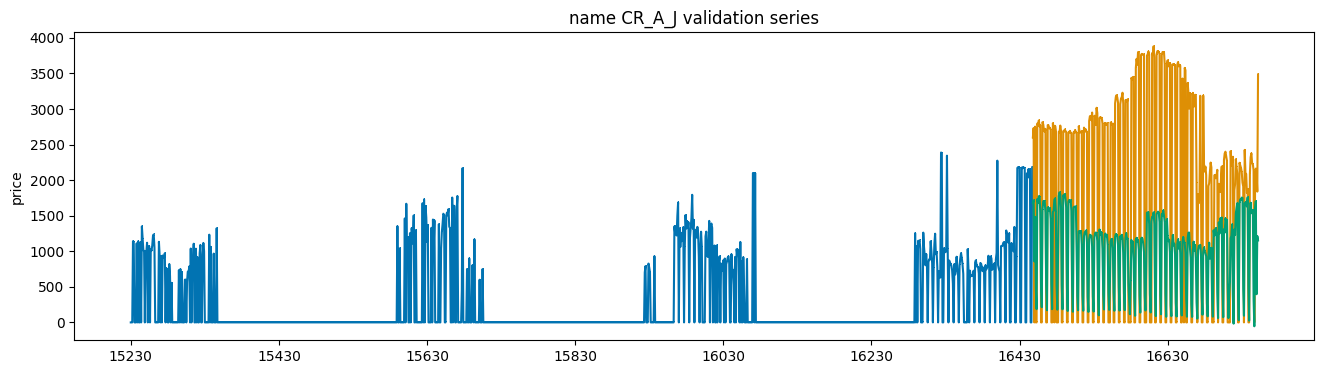

RMSE: 149.2760924885269


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 28%|██▊       | 11/39 [03:59<09:51, 21.12s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

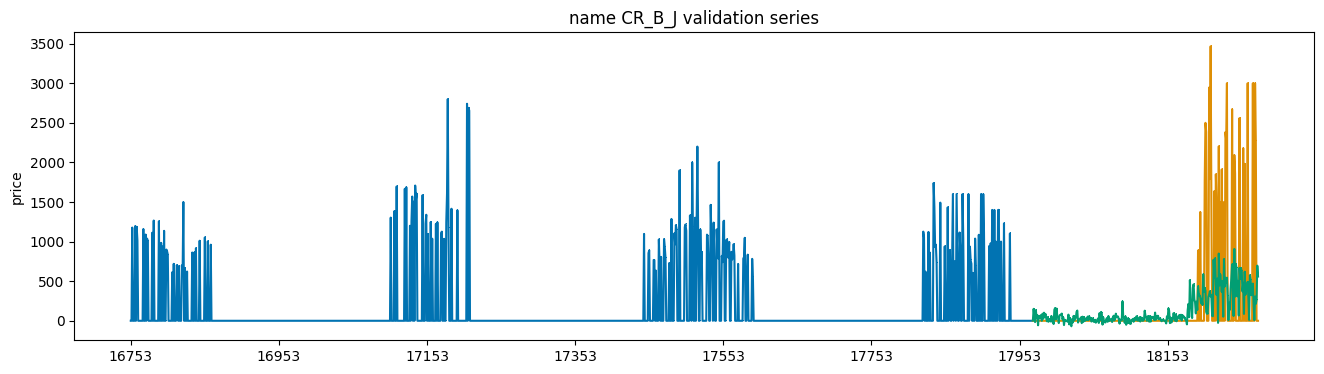

RMSE: 189.35464578531244


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 31%|███       | 12/39 [04:16<08:58, 19.94s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

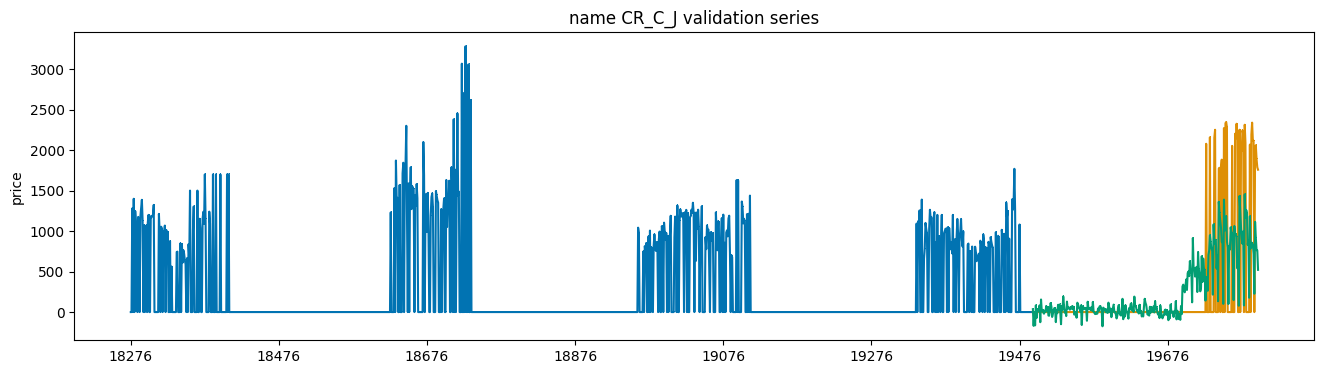

RMSE: 284.54003883865374


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 33%|███▎      | 13/39 [04:35<08:31, 19.67s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

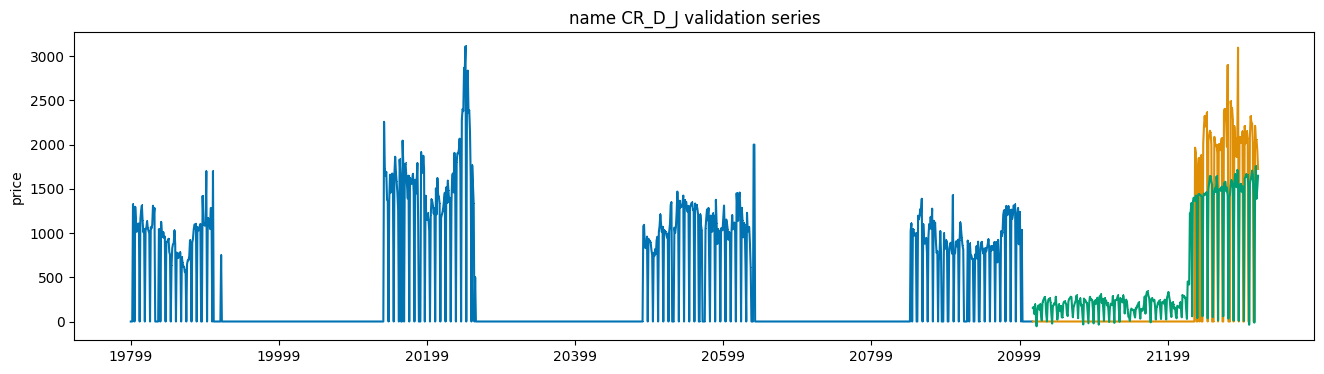

RMSE: 63.798216934756724


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 36%|███▌      | 14/39 [04:53<08:00, 19.21s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

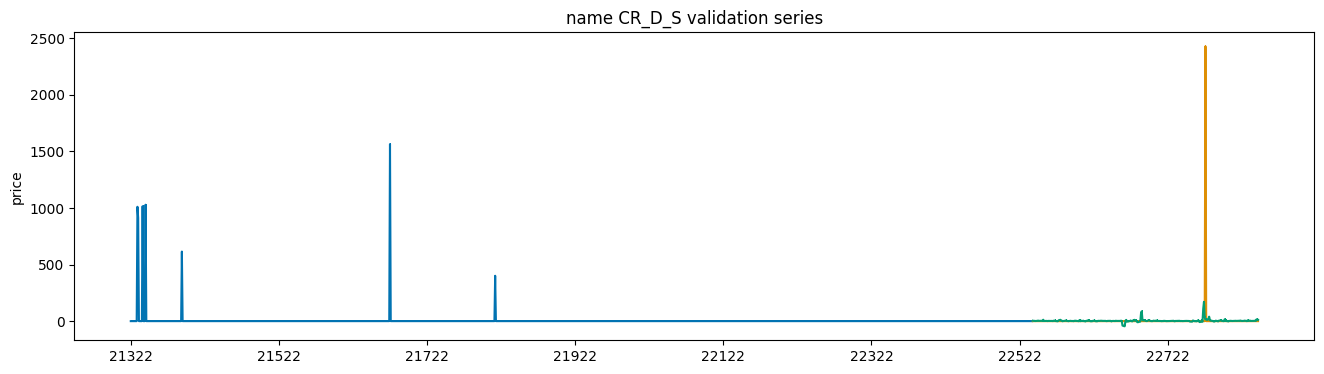

RMSE: 62.21514298096286


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 38%|███▊      | 15/39 [05:09<07:12, 18.01s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

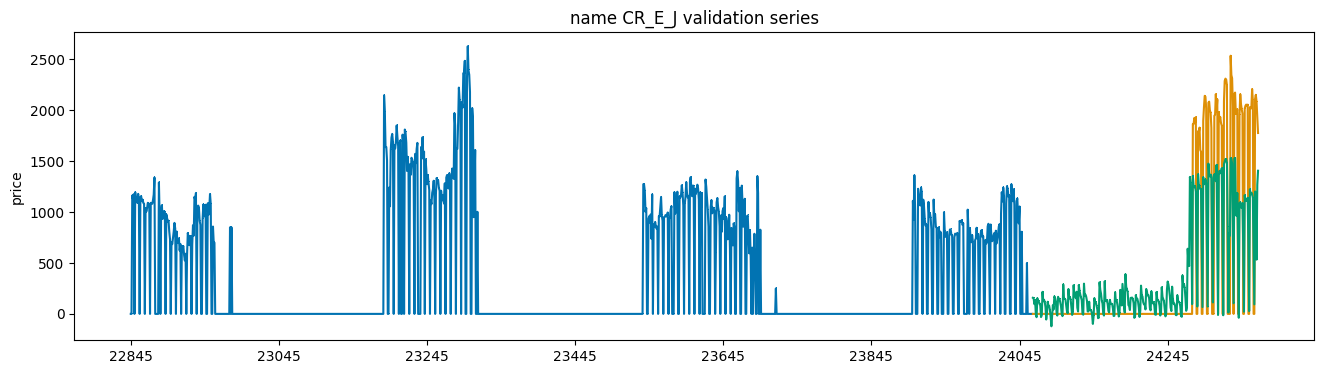

RMSE: 81.52166689655634


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 41%|████      | 16/39 [05:27<06:56, 18.10s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

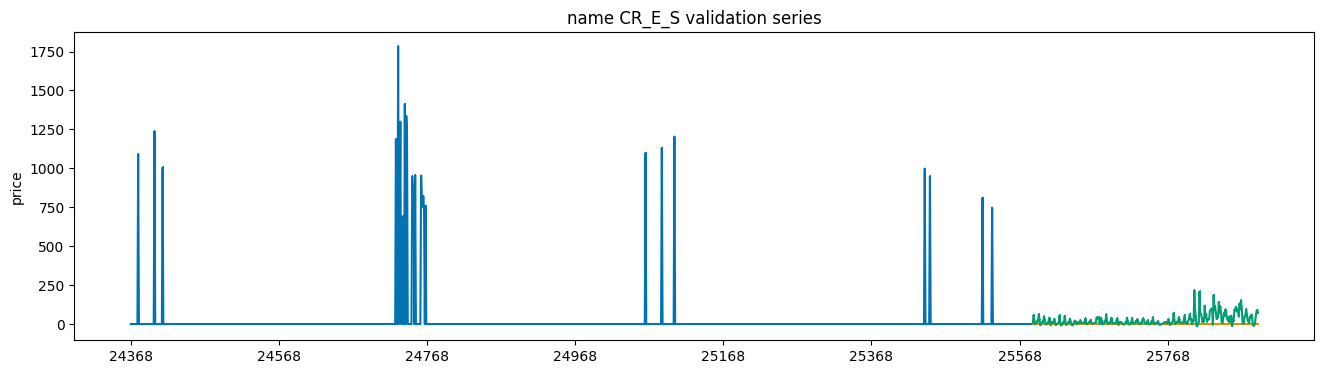

RMSE: 103.04342648101947


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 44%|████▎     | 17/39 [05:43<06:27, 17.63s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

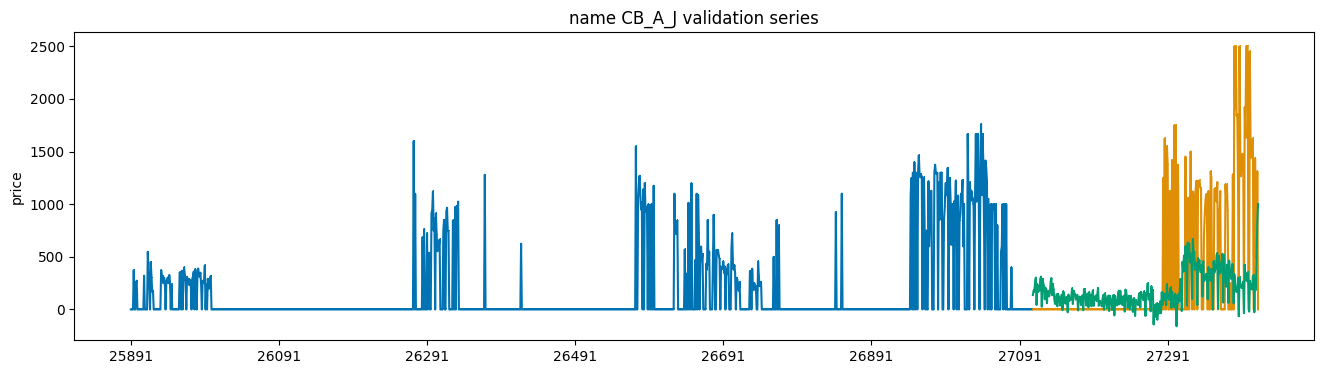

RMSE: 143.90481030622095


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 46%|████▌     | 18/39 [06:02<06:14, 17.83s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

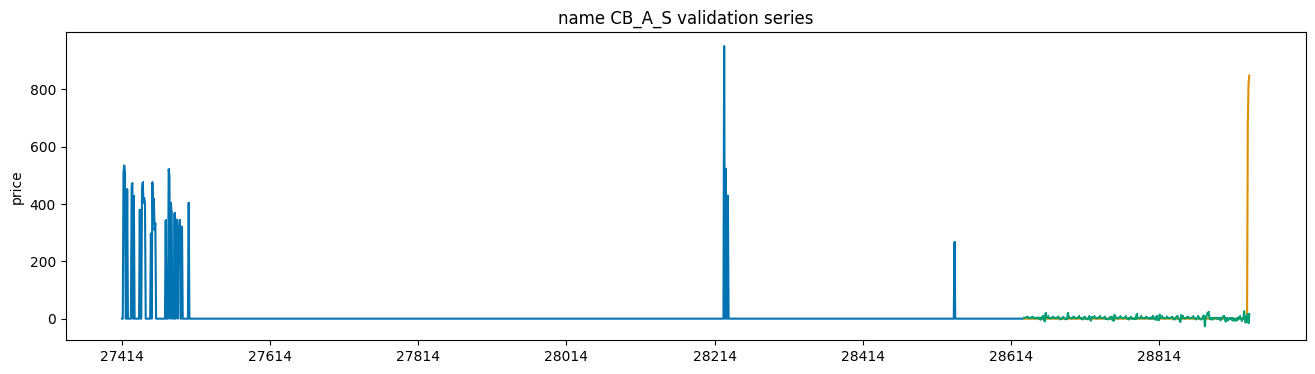

RMSE: 45.57930580133425


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 49%|████▊     | 19/39 [06:18<05:49, 17.48s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

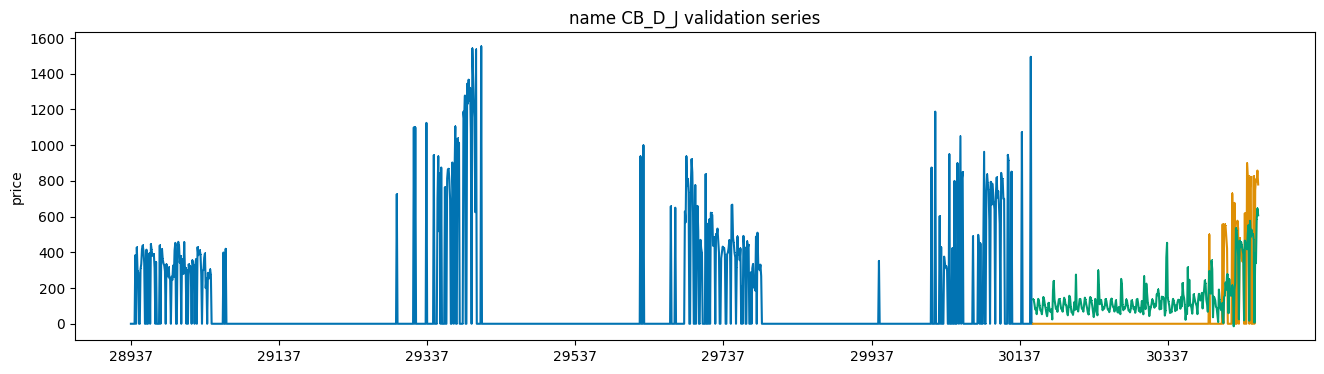

RMSE: 77.48618249200202


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 51%|█████▏    | 20/39 [06:37<05:36, 17.69s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

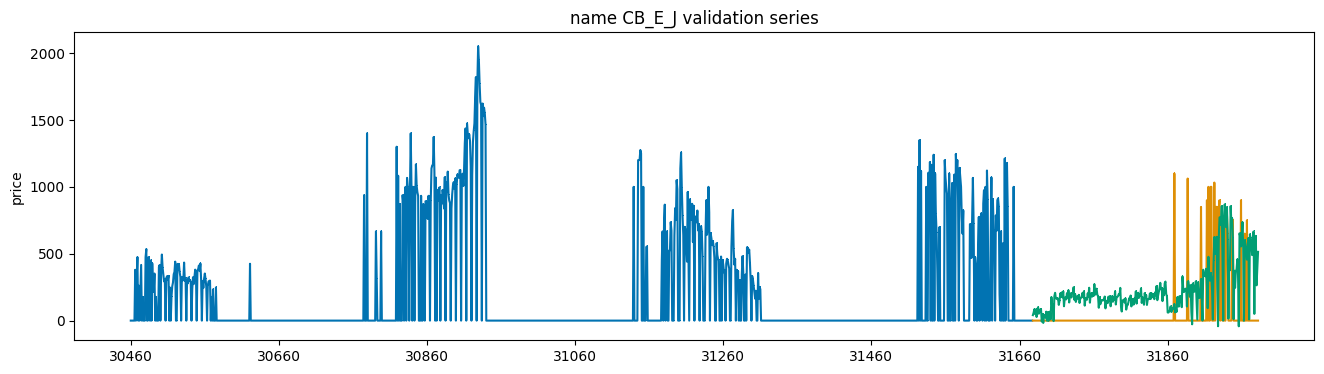

RMSE: 131.64936843863535


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 54%|█████▍    | 21/39 [06:55<05:22, 17.94s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

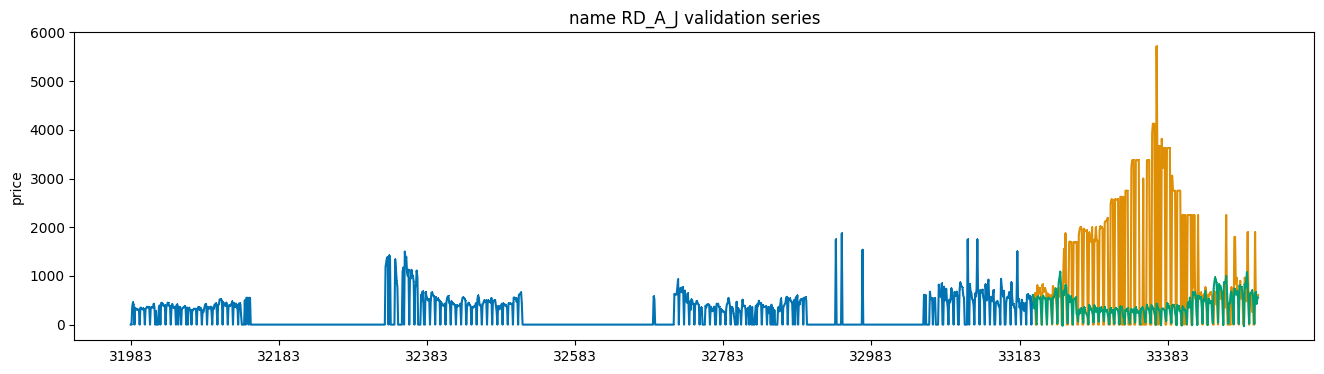

RMSE: 94.68462877854782


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 56%|█████▋    | 22/39 [07:14<05:08, 18.17s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

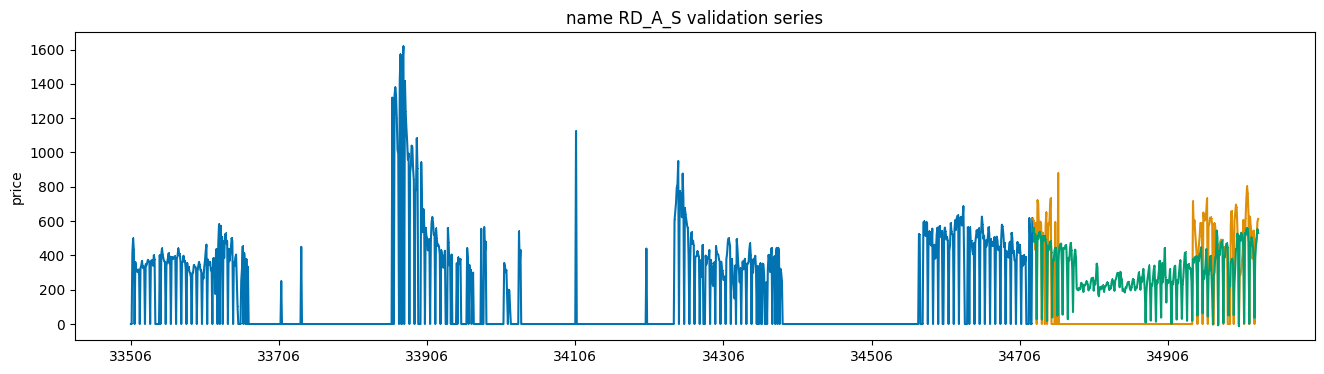

RMSE: 36.44350317017976


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 59%|█████▉    | 23/39 [07:31<04:46, 17.89s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

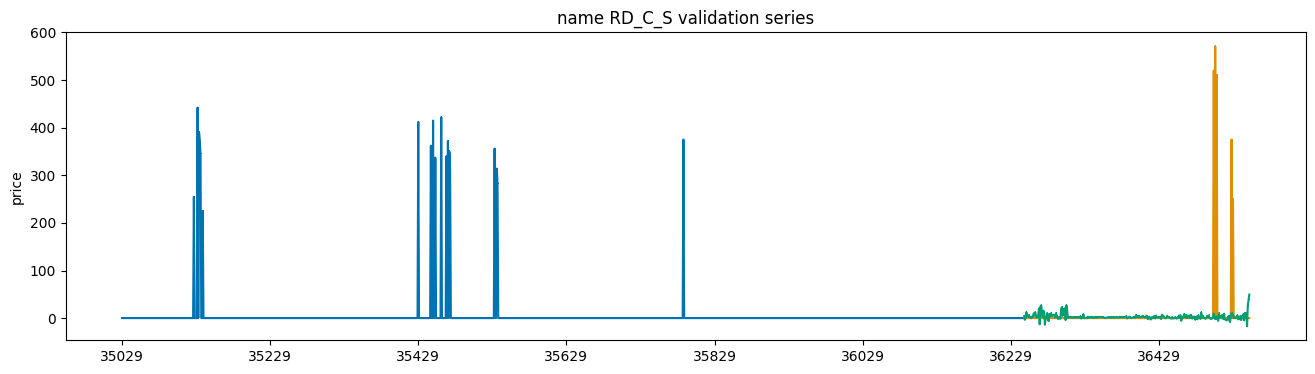

RMSE: 30.513649563968663


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 62%|██████▏   | 24/39 [07:46<04:15, 17.03s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

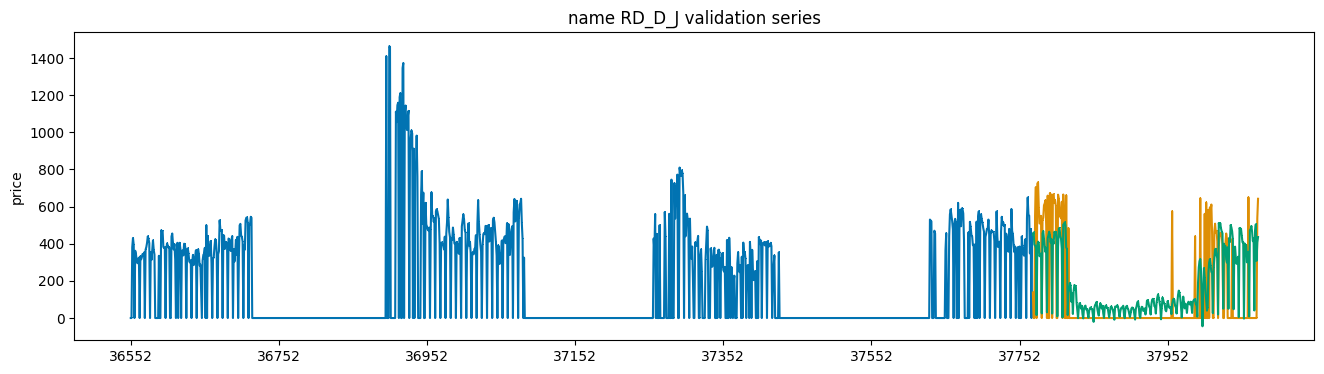

RMSE: 66.98205323997625


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 64%|██████▍   | 25/39 [08:03<03:57, 16.96s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

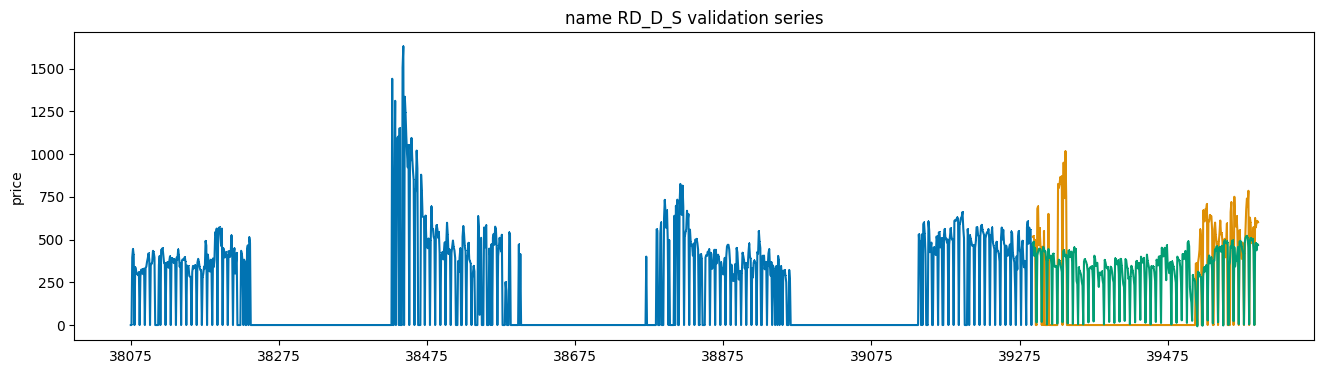

RMSE: 44.17922397496966


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 67%|██████▋   | 26/39 [08:20<03:43, 17.16s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

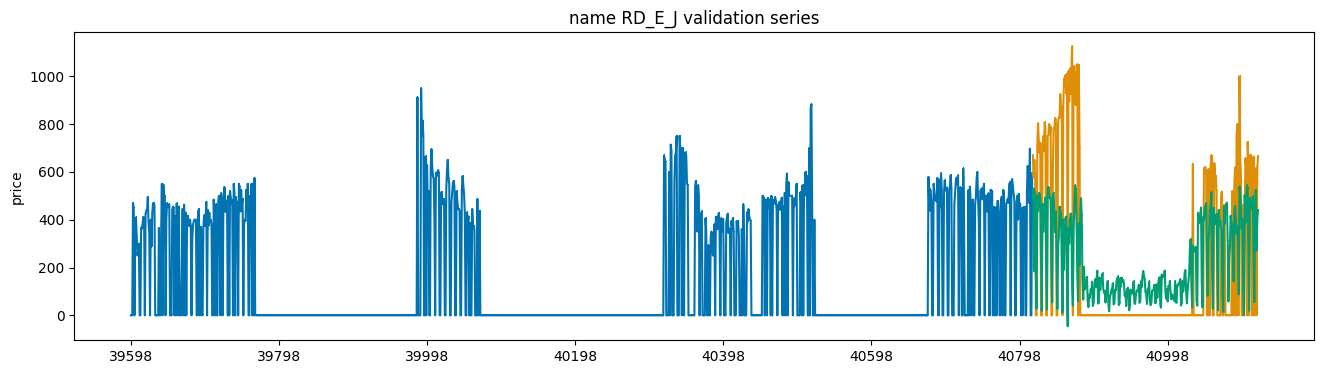

RMSE: 56.47370321036978


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 69%|██████▉   | 27/39 [08:37<03:23, 16.97s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

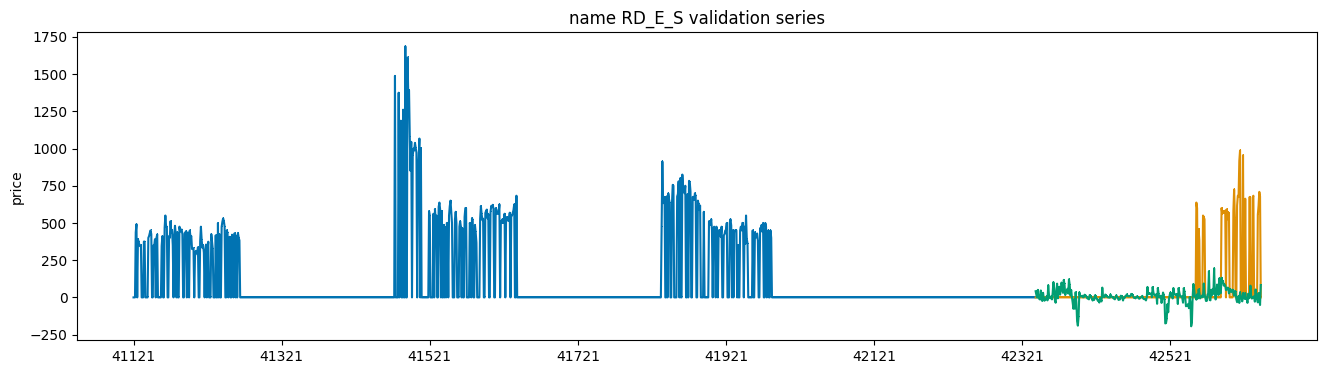

RMSE: 86.33179378604221


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 72%|███████▏  | 28/39 [08:54<03:05, 16.88s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

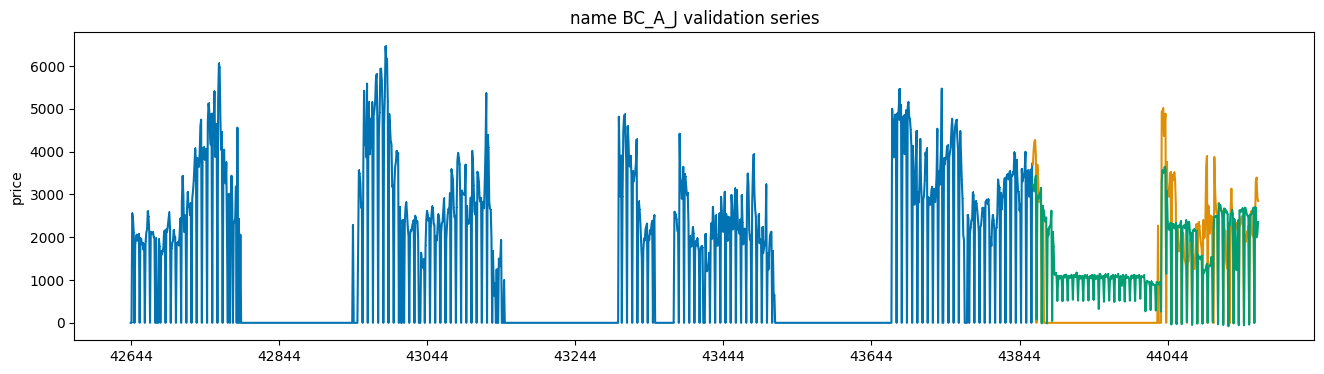

RMSE: 209.33043030278063


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 74%|███████▍  | 29/39 [09:11<02:49, 16.96s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

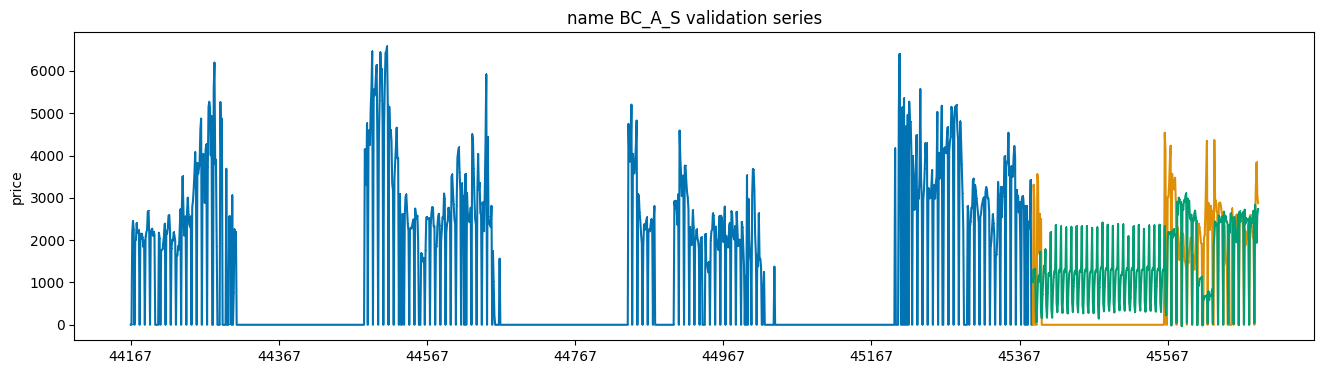

RMSE: 217.90446236059722


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 77%|███████▋  | 30/39 [09:28<02:33, 17.03s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

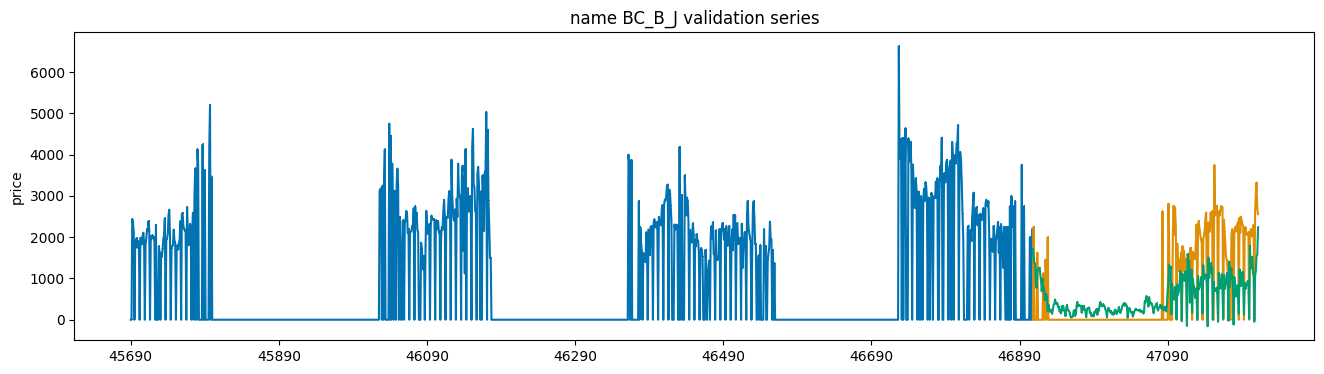

RMSE: 418.4644041813785


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 79%|███████▉  | 31/39 [09:45<02:15, 16.92s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

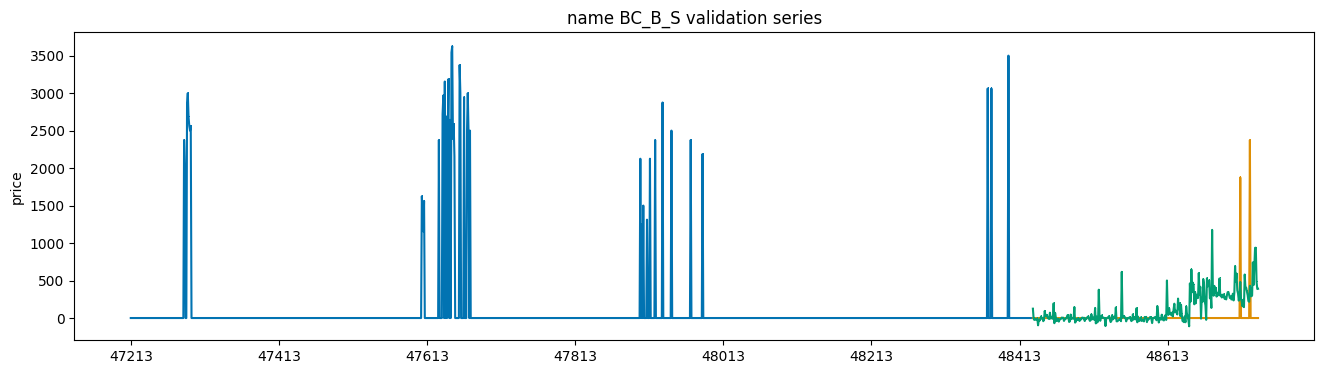

RMSE: 232.60903338510667


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 82%|████████▏ | 32/39 [09:59<01:53, 16.21s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

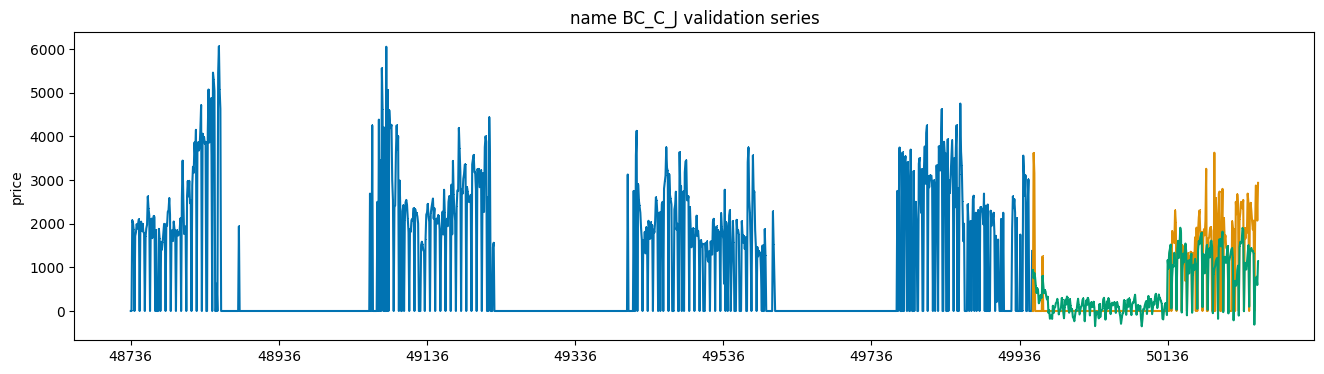

RMSE: 370.88469036222244


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 85%|████████▍ | 33/39 [10:16<01:38, 16.38s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

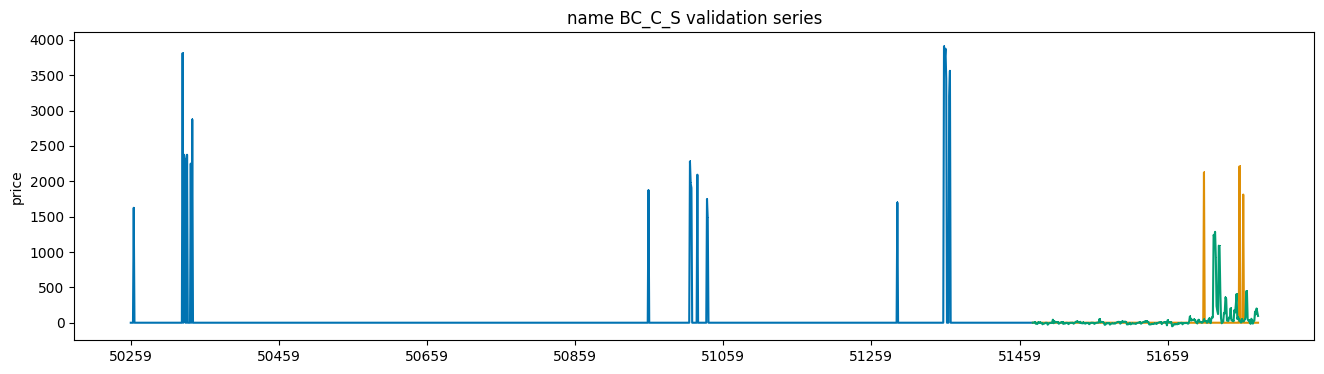

RMSE: 150.9633653775474


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 87%|████████▋ | 34/39 [10:31<01:19, 15.85s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

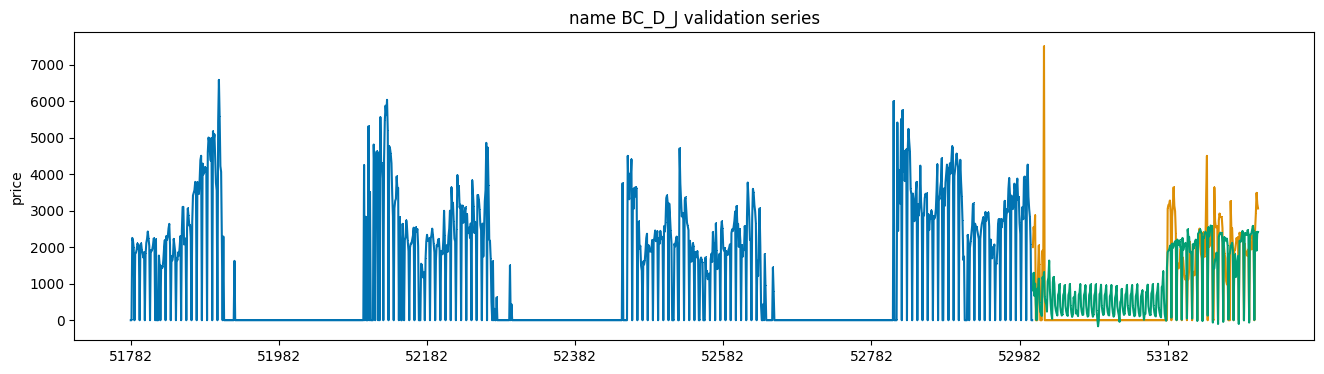

RMSE: 240.65092556034617


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 90%|████████▉ | 35/39 [10:48<01:05, 16.28s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

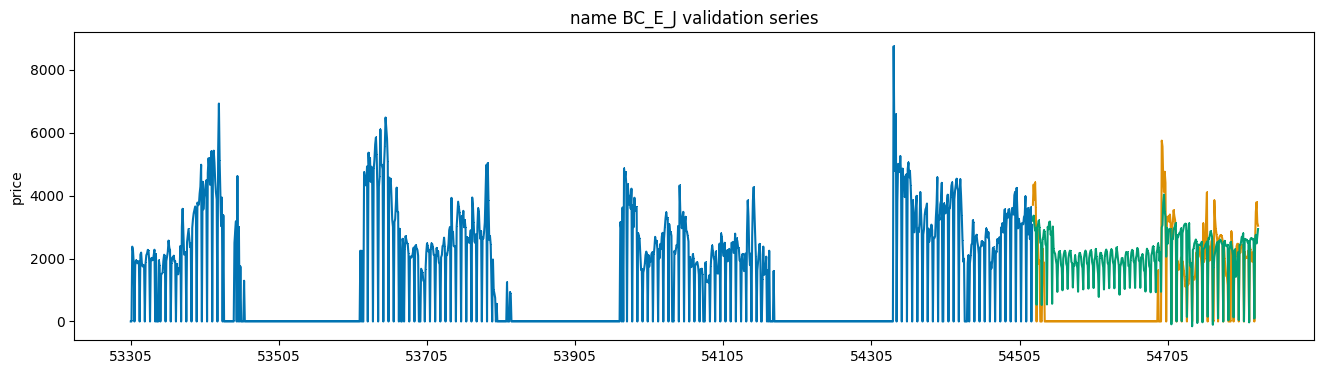

RMSE: 271.3939769815931


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 92%|█████████▏| 36/39 [11:05<00:50, 16.68s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

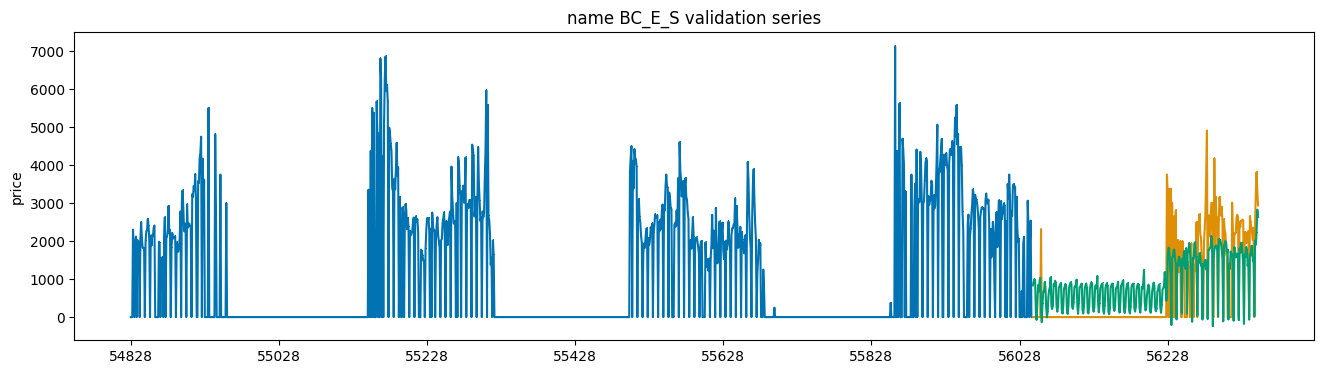

RMSE: 399.17967838151475


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 95%|█████████▍| 37/39 [11:23<00:33, 16.81s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

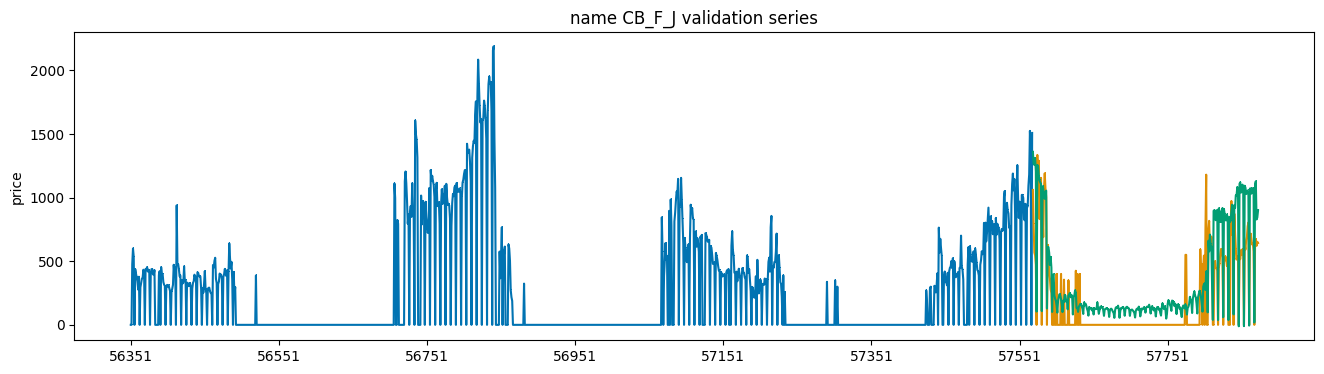

RMSE: 29.620489375222764


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 97%|█████████▋| 38/39 [11:42<00:17, 17.67s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

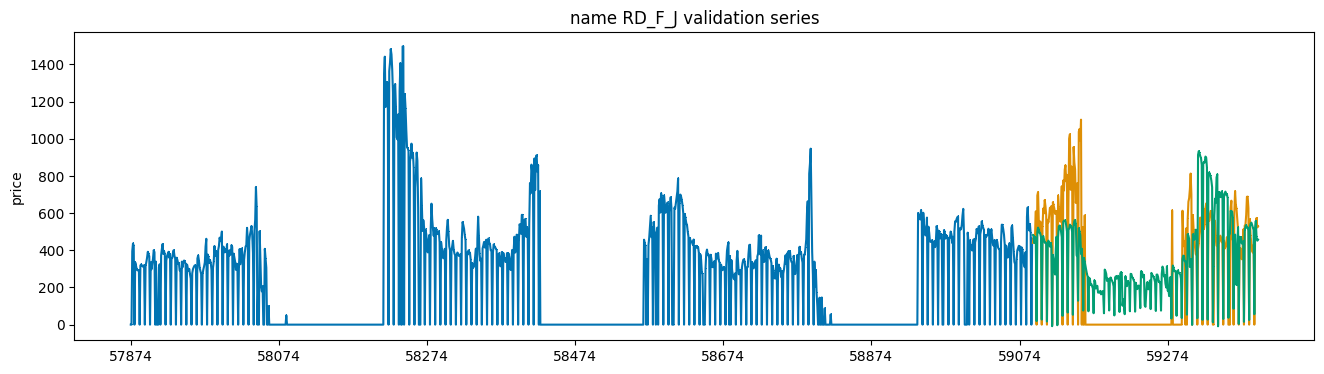

RMSE: 21.715120497910295


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
100%|██████████| 39/39 [12:00<00:00, 18.48s/it]


In [150]:
# import optuna
from sklearn.model_selection import TimeSeriesSplit

# best_params_dict = {}
# predictions_dict = {}
predictions = []
rmse_scores = []

for i in tqdm(train_df.name.unique()):
    X = train_df[train_df.name == i].drop(columns=['ID', 'price', 'supply', 'name'])
    y = train_df[train_df.name == i]['price']
    test_X = test_df[test_df.name == i].drop(columns=['ID', 'name'])


    X_train, X_valid, y_train, y_valid = temporal_train_test_split(X, y, test_size=0.2)

#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=70)  # 적절한 n_trials 값 선택

    # 최적의 하이퍼파라미터 저장
#     best_params_dict[i] = study.best_params

    from sklearn.ensemble import StackingRegressor

    estimators = [
        ("rf", RandomForestRegressor(random_state=SEED)),
        ("lgbm",LGBMRegressor(random_state=SEED)),
        ("xgboost",XGBRegressor(random_state=SEED)),
        ("cat",CatBoostRegressor(random_state=SEED,iterations=200, verbose = 0))
    ]

    params = {
        "estimators" : estimators,
    #     "final_estimator" : LinearRegression(**best_params),
        "final_estimator" : LinearRegression(),
        "cv" : cv,
        "n_jobs":-1
    }

    model_ensemble= StackingRegressor(**params)

    model_ensemble.fit(X_train, y_train)
    X_pred = model_ensemble.predict(X_train)
    X_rmse = np.sqrt(mean_squared_error(y_train, X_pred))
    rmse_scores.append(X_rmse)

    pred = model_ensemble.predict(X_valid)
    pred = pd.Series(pred)
    pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
    plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])
    plt.title(f'name {i} validation series')
    plt.show()
    print(f'RMSE: {X_rmse}')

    model_ensemble.fit(X,y)
    pred_target = model_ensemble.predict(test_X)
    predictions.append(pred_target)

    # predictions_dict[i] = pd.Series(pred)





In [151]:
sum(rmse_scores) / len(rmse_scores)

313.2584477494072

In [152]:
predictions

[array([3124.48879565,  259.756174  , 3309.35586243, 3362.33014362,
        3349.25706541, 3462.85649527, 3364.56187591, 3462.61213984,
         205.13788941, 3525.43999748, 3544.08995722, 3568.63811454,
        3438.28639312, 3700.7832851 , 3400.12711702,  196.22283756,
        4060.34411272, 4114.00329662, 4080.29176807, 4010.53197179,
        4155.06804386, 3938.9451601 ,  595.27449983, 4147.34398969,
        3806.43814358, 4593.25155221, 4369.07184333, 4447.80930607]),
 array([3800.93594564,  453.95780061, 3830.31784273, 3851.42042458,
        4008.60226291, 3972.10805808, 3898.80395529, 3780.82739534,
         347.98881127, 3870.887069  , 3986.00658839, 3984.5223936 ,
        4012.11167637, 4015.33646115, 4076.39760458,  301.55794161,
        4322.00181404, 4396.65716808, 4354.28772311, 4359.19130684,
        4355.11030116, 4139.55905955,  354.83047206, 4352.77628452,
        4424.8026349 , 4530.19791047, 4594.0267839 , 4645.10695871]),
 array([3328.10055026,  592.96694972, 3471.3

In [153]:
total_prediction = []

for i in predictions:
    for j in i :
        total_prediction.append(j)


In [154]:
for i in total_prediction :
    print(i)

3124.4887956482626
259.75617400047065
3309.355862426482
3362.3301436222087
3349.2570654091187
3462.8564952742386
3364.5618759120744
3462.6121398388395
205.13788941455425
3525.439997483781
3544.089957215408
3568.638114544826
3438.286393122057
3700.783285099824
3400.1271170177865
196.22283756427066
4060.344112715684
4114.003296616904
4080.291768068019
4010.531971789315
4155.068043855513
3938.945160097166
595.2744998322388
4147.343989692405
3806.4381435800497
4593.251552207004
4369.071843330626
4447.809306071782
3800.9359456390907
453.9578006129741
3830.3178427326434
3851.4204245845885
4008.602262911835
3972.108058082956
3898.803955294415
3780.8273953370076
347.98881126673314
3870.887069004387
3986.006588386016
3984.5223935957515
4012.111676367877
4015.3364611511083
4076.3976045757145
301.55794160567615
4322.001814043611
4396.657168075688
4354.287723109463
4359.191306841685
4355.110301162093
4139.559059547975
354.8304720637213
4352.776284521311
4424.80263490152
4530.19791047228
4594.02678

In [155]:
len(total_prediction)

1092

In [156]:
total_prediction = np.array(total_prediction)

In [157]:
total_prediction[total_prediction < 0] = 0

In [158]:
total_prediction

array([3124.48879565,  259.756174  , 3309.35586243, ...,  511.26899178,
        453.49432088,  437.4477016 ])

In [159]:
submission['answer'] = total_prediction
submission

,ID,answer
0,TG_A_J_20230304,3124.488796
1,TG_A_J_20230305,259.756174
2,TG_A_J_20230306,3309.355862
3,TG_A_J_20230307,3362.330144
4,TG_A_J_20230308,3349.257065
...,...,...
1087,RD_F_J_20230327,450.248049
1088,RD_F_J_20230328,522.779615
1089,RD_F_J_20230329,511.268992
1090,RD_F_J_20230330,453.494321


In [160]:
submission.to_csv('submission22_1112.csv', index=False)